<center> <h1>Adding Monte Carlo Simulation to Machines Manufacturing Capital Budgeting Model</h1> </center>
<center> <h4>Erick Daniel Rodríguez Villafuerte</h4> </center>

- [**Overview**](#Overview): Brief description of the problem and the model
- [**Setup**](#Setup): Runs any imports and other setup
- [**Inputs**](#Inputs): Defines the inputs for the model
- [**Machines Output**](#Machines-Output): Determining the output of a machine and the output for multiple machines
- [**Demand**](#Demand): Determines the number of units demanded per year, based on the number of advertising years
- [**Cash Flows**](#Cash-Flows): Combines the machines output and demand to determine the quantity transacted each year. Then uses this information as well as phone prices and costs, machine scrap values, and machine/advertising costs to determine the cash flows in each year.
- [**NPV**](#NPV): Calculates a net present value (NPV) from the cash flows.
- [**Final Outputs**](#Final-Outputs): Shows the final output cash flows and NPV with formating.
- [**Monte Carlo Simulation**](#Monte-Carlo-Simulation): Extension to a given model, adds MCS analysis.

## Overview 
### The Problem

<div style="text-align: justify"> You work for a new startup that is trying to manufacture phones. You are tasked with building a model which will help determine how many machines to invest in and how much to spend on marketing. Each machine produces $n_{output}$ phones per year. Each phone sells for $p_{phone}$ and costs $c_{phone}$ in variable costs to produce. After $n_{life}$ years, the machine can no longer produce output, but may be scrapped for $p_{scrap}$. The machine will not be replaced, so you may end up with zero total output before your model time period ends. </div>
<br>
<div style="text-align: justify"> Equity investment is limited, so in each year you can spend $c_{machine}$ to either buy a machine or buy advertisements. In the first year you must buy a machine. Any other machine purchases must be made one after another (advertising can only begin after machine buying is done). Demand for your phones starts at $d_1$. Each time you advertise, demand increases by $g_d$%. The prevailing market interest rate is $r$.
</div>

### Notes
- Model is limited to 20 years and a maximum of 5 machines.
- For simplicity, assume that $c_{machine}$ is paid in every year, even after all machines have shut down.
- Ensure that you can change the inputs and the outputs change as expected.
- For simplicity, assume that fractional phones can be sold, you do not need to round the quantity transacted.




## Setup

Setup for the later calculations are here. The necessary packages are imported.

In [1]:
from dataclasses import dataclass
import numpy_financial as npf
import itertools
import pandas as pd
%matplotlib inline
import random
import statsmodels.api as sm

## Inputs

All of the inputs for the model are defined here. A class is constructed to manage the data, and an instance of the class containing the default inputs is created.

In [2]:
@dataclass
class ModelInputs:
    n_phones: float = 100000
    price_scrap: float = 50000
    price_phone: float = 500
    cost_machine_adv: float = 1000000
    cogs_phone: float = 250
    n_life: int = 10
    n_machines: int = 5
    d_1: float = 100000
    g_d: float = 0.2
    max_year: float = 20
    interest: float = 0.05
                
model_data = ModelInputs()
model_data

ModelInputs(n_phones=100000, price_scrap=50000, price_phone=500, cost_machine_adv=1000000, cogs_phone=250, n_life=10, n_machines=5, d_1=100000, g_d=0.2, max_year=20, interest=0.05)

To start off, we will create several functions to solve this problem, this will help to solve similar projects with little to none changes instead of having to hard-code each time we want to solve the project. Also, this will allow us to add more analysis later to the project.

## Machine Outputs

The first set of functions will be related to the enterprise machines. <br>
They will serve to determine:
- Machines bought per year
- Number of working machines per year
- Broken machines per year
- Scrap value of a broken machine per year

In [3]:
def machines_bought_per_year(data: ModelInputs):
    '''
    Creates a list of booleans when a machine is bought, it will be true for the first years according 
    to the number of machines up to the last year of the model.
    '''
    years = list(range(1, data.max_year + 1))
    buy_machine = []
    for year in years:
            # This will create a list of booleans when a machine is bought
            if year <= data.n_machines:
                buy_machine.append(True)
            else:
                buy_machine.append(False)
    return buy_machine

In [4]:
def broken_machines_per_year(data: ModelInputs):
    '''
    Creates a list of booleans when a machine breakes down, it will be true after each machine bought
    ends the years of life (given in model inputs)
    '''
    # This creates a list of booleans when a machine breaks down
    years = list(range(1, data.max_year + 1))
    broken_machine = []
    for year in years:
        if data.n_life % year == data.n_life and year <= (data.n_machines + data.n_life):
            broken_machine.append(True)
        else:
            broken_machine.append(False)
    return broken_machine

In [5]:
def working_machines_per_year():
    '''
    This will create a list of ints when a machine is bought, when a machine
    breaks down and when none of these happens at the same time (1, -1, 0), respectevely
    '''
    working_machine = []
    machines_bought = machines_bought_per_year(model_data)
    broken_machines = broken_machines_per_year(model_data)
    for i, j in zip(machines_bought, broken_machines):
        if i == True and j == False:
            working_machine.append(1)
        elif i == False and j == True:
            working_machine.append(-1)
        else:
            working_machine.append(0)
    working_machine = list(itertools.accumulate(working_machine))
    return working_machine

In [6]:
def scrap_value_per_year(data: ModelInputs):
    '''
    This function returns the scrap value per year, will only return a value when a machine
    breakes down
    '''
    scrap_value = []
    broken_machines = broken_machines_per_year(data)
    for i in broken_machines:
        if i == True:
            scrap_value.append(data.price_scrap)
        elif i == False:
            scrap_value.append(0)
    return scrap_value

## Demand

Now that we have the information for all the machines, we can start to look at the demand of phones, which will increase after all machines are bought since the company will start to invest in advertisement. <br> <br>
With that in mind, we can get the number of phones sold per year, recall that for simplicity of this project, fractional phones can be sold.

In [7]:
def demand_of_phones(data: ModelInputs):
    '''
    This function creates a list of the demanded phones, will start increasing after all machines are bought
    '''
    demand = []
    machines_bought = machines_bought_per_year(data)
    for i in machines_bought:
        if i == True:
            demand.append(data.d_1)
        elif i == False:
            demand.append(demand[-1] * (1 + data.g_d))
    return demand

In [8]:
def phones_sold_per_year(data: ModelInputs):
    '''
    This function creates the number of phones produced depending on the number
    of working machines, then it returns phones sold according to the demand 
    per year
    '''
    working_machines = working_machines_per_year()
    phones_produced = [i * data.n_phones for i in working_machines]
    demand = demand_of_phones(data)
    phones_sold = []
    for p, d in zip(phones_produced, demand):
        if p >= d:
            phones_sold.append(d)
        else:
            phones_sold.append(p)
    return phones_sold

Numer of phones sold per year

In [9]:
phones_sold_per_year(model_data)

[100000,
 100000,
 100000,
 100000,
 100000,
 120000.0,
 144000.0,
 172800.0,
 207360.0,
 248832.0,
 298598.39999999997,
 300000,
 200000,
 100000,
 0,
 0,
 0,
 0,
 0,
 0]

## Cash Flows

We now have all the necessary information to get the cash flows for the company

In [10]:
def cash_flows_per_year(data: ModelInputs):  
    '''
    This function takes the inputs of the class and returns
    the cash flows of the project
    '''
    revenues = []
    money_in = []
    cogs = []
    money_out = []
    phones = phones_sold_per_year(data)
    scrap = scrap_value_per_year(data)
    
    # This creates a list of revenues, which multiplies each number of phones
    # sold by year by the price given in the class
    revenues = [i * data.price_phone for i in phones]
    
    # This creates a list of cogs, which multiplies each number of phones
    # sold by year by the variable cost per phone given in the class
    cogs = [i * data.cogs_phone for i in phones]
    
    # This creates a list of the revenues plus the scrap value of the machines per year
    money_in = [x + y for x, y in zip(revenues, scrap)]
    
    # This creates a list of cogs plus cash spent per year
    money_out = [i + data.cost_machine_adv for i in cogs]
    
    # The money-in minus the money-out of each year will be our cash flow
    cash_flows = [x - y for x, y in zip(money_in, money_out)]
    return cash_flows

In [11]:
cash_flows_per_year(model_data)

[24000000,
 24000000,
 24000000,
 24000000,
 24000000,
 29000000.0,
 35000000.0,
 42200000.0,
 50840000.0,
 61208000.0,
 73699599.99999999,
 74050000,
 49050000,
 24050000,
 -950000,
 -1000000,
 -1000000,
 -1000000,
 -1000000,
 -1000000]

## NPV

This section determines the NPV of the project with the current inputs. This is the main output from the model.

In [12]:
def model_npv(data: ModelInputs):
    '''
    Determines the NPV of the entire phone manufacturing capital budget problem.
    Uses the cash flows from cash_flows_per_year and calculates the NPV from them
    '''
    # numpy NPV assumes first year is zero, we don't have a year zero so add a zero cash flow
    cf = cash_flows_per_year(data)
    all_cash_flows = [0] + cf
    npv = npf.npv(data.interest, all_cash_flows)
    return npv

In [13]:
npv = model_npv(model_data)
npv

369276542.47415346

## Final Outputs

We have calculated all the cash flows for the years and the corresponding net present value, just to make it more readable, we will format the answers.

In [14]:
formatted_cash_flows = [f'Year {i + 1}: ${cf:,.0f}' for i, cf in enumerate(cash_flows_per_year(model_data))]
print('Cash Flows:\n' + '\n'.join(formatted_cash_flows))
print(f'\n\nNPV: ${npv:,.0f}')

Cash Flows:
Year 1: $24,000,000
Year 2: $24,000,000
Year 3: $24,000,000
Year 4: $24,000,000
Year 5: $24,000,000
Year 6: $29,000,000
Year 7: $35,000,000
Year 8: $42,200,000
Year 9: $50,840,000
Year 10: $61,208,000
Year 11: $73,699,600
Year 12: $74,050,000
Year 13: $49,050,000
Year 14: $24,050,000
Year 15: $-950,000
Year 16: $-1,000,000
Year 17: $-1,000,000
Year 18: $-1,000,000
Year 19: $-1,000,000
Year 20: $-1,000,000


NPV: $369,276,542


## Monte Carlo Simulation

As we recall, project is based manly on several functions, this will facilitate the Monte Carlo Simulation extension

### Level 1
- You are concerned the NPV could be heavily affected by changes in the interest rate. Instead of fixing it, draw it from a normal distribution with mean of 7% and standard deviation of 2%. <br><br>
- Run the model 10,000 times and collect the NPV results. Visualize the results. Create a table of probabilities and the minimum NPV we could expect with that probability. Output the chance that the NPV will be more than \\$400,000,000.

### Level 2
- Continue from the first lab exercise. Now you are also concerned that your assembly line will not be as efficient and so the number of phones per machine will be lower. So draw that from a normal distribution with mean 100,000 and standard deviation of 20,000.<br><br>
- As you run the model, also store what were the interest and number of phones corresponding to the NPV. You want to see which has a greater impact on the NPV: interest or number of phones. Visualize the relationship between interest and NPV, and the relationship between number of phones and NPV. Also run a regression to quantitatively determine which has a greater effect.

## Simulation Inputs

In [33]:
@dataclass
class SimluationInputs:
    interest_mean: float = 0.07
    interest_std: float = 0.02
    n_phones_std: float = 20000
    n_iterations: int = 10000    
        
sim_data = SimluationInputs()
data =model_data

### Level 1

In [16]:
def simulation(sim_data):
    interest = random.normalvariate(sim_data.interest_mean, sim_data.interest_std)
    new_data = ModelInputs(interest=interest)
    npv = model_npv(new_data)
    return interest, npv

def simulations_df(sim_data):
    results = [simulation(sim_data) for i in range(sim_data.n_iterations)]
    df = pd.DataFrame(results, columns = ['Interest', 'NPV'])
    return df

In [17]:
def styled_df(df):
    return df.style.format({
        'Interest': '{:.2%}',
        'NPV': '${:,.0f}'
    }).background_gradient(cmap='RdYlGn', subset='NPV')

In [18]:
df = simulations_df(sim_data)

In [19]:
styled_df(df.head())

,Interest,NPV
0,4.99%,"$369,662,594"
1,8.08%,"$295,146,335"
2,5.52%,"$354,994,473"
3,5.50%,"$355,634,014"
4,5.53%,"$354,745,486"


<AxesSubplot:ylabel='Frequency'>

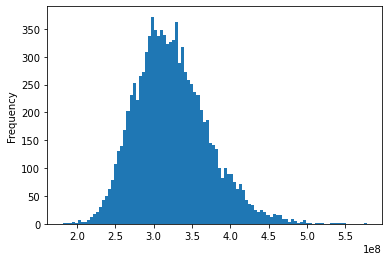

In [20]:
df['NPV'].plot.hist(bins=100)

In [21]:
styled_df(df.quantile([i/20 for i in range(1,20)]))

,Interest,NPV
0.05,3.65%,"$254,418,333"
0.1,4.40%,"$267,073,274"
0.15,4.92%,"$275,526,637"
0.2,5.30%,"$283,616,028"
0.25,5.61%,"$290,468,288"
0.3,5.92%,"$296,644,903"
0.35,6.20%,"$302,129,959"
0.4,6.46%,"$307,888,353"
0.45,6.70%,"$313,366,445"
0.5,6.96%,"$319,485,343"


In [22]:
cutoff = 400000000
pct = (df['NPV'] > cutoff).astype(int).mean()
print(f'There is a {pct: .2%} chance that NPV will be greater than ${cutoff: ,.0f}')

There is a  6.84% chance that NPV will be greater than $ 400,000,000


### Level 2

In [34]:
def simulation(sim_data):
    interest = random.normalvariate(sim_data.interest_mean, sim_data.interest_std)
    n_phones = random.normalvariate(data.n_phones, sim_data.n_phones_std)
    new_data = ModelInputs(interest=interest, n_phones=n_phones)
    npv = model_npv(new_data)
    return interest, n_phones, npv

def simulations_df(sim_data):
    results = [simulation(sim_data) for i in range(sim_data.n_iterations)]
    df = pd.DataFrame(results, columns = ['Interest', 'Number of Phones', 'NPV'])
    return df

In [35]:
def styled_df(df):
    return df.style.format({
        'Interest': '{:.2%}',
        'Number of Phones': '{:,.0f}',
        'NPV': '${:,.0f}'
        
    }).background_gradient(cmap='RdYlGn', subset='NPV')

<AxesSubplot:ylabel='Frequency'>

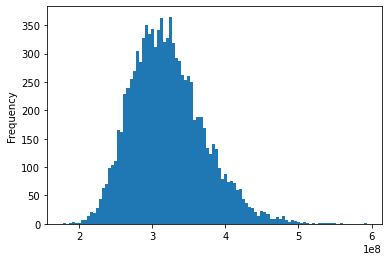

In [36]:
df = simulations_df(sim_data)
df['NPV'].plot.hist(bins=100)

In [37]:
styled_df(df.quantile([i/20 for i in range(1,20)]))

,Interest,Number of Phones,NPV
0.05,3.67%,"66,810","$248,932,291"
0.1,4.38%,"73,895","$262,248,137"
0.15,4.87%,"79,036","$270,785,842"
0.2,5.27%,"83,116","$278,282,260"
0.25,5.58%,"86,770","$285,553,302"
0.3,5.89%,"89,684","$291,686,953"
0.35,6.17%,"92,479","$297,911,385"
0.4,6.43%,"95,066","$304,212,578"
0.45,6.70%,"97,583","$310,426,693"
0.5,6.95%,"100,321","$316,282,047"


In [38]:
cutoff = 400000000
pct = (df['NPV'] > cutoff).astype(int).mean()
print(f'There is a {pct: .2%} chance that NPV will be greater than ${cutoff: ,.0f}')

There is a  7.07% chance that NPV will be greater than $ 400,000,000


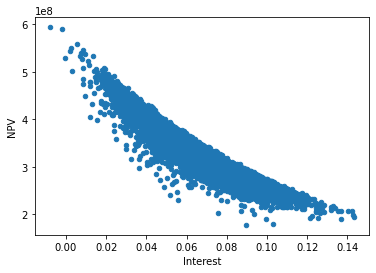

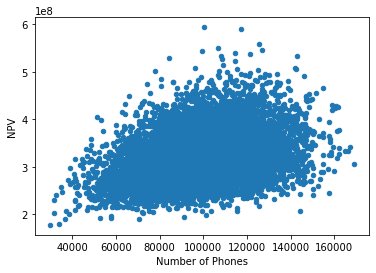

In [39]:
for col in ['Interest', 'Number of Phones']:
    df.plot.scatter(x=col, y='NPV')

In [40]:
X = sm.add_constant(df[['Interest', 'Number of Phones']])
y = df['NPV']

model = sm.OLS(y, X, hasconst=True)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    NPV   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 1.715e+05
Date:                Wed, 13 Jan 2021   Prob (F-statistic):               0.00
Time:                        19:46:16   Log-Likelihood:            -1.7363e+05
No. Observations:               10000   AIC:                         3.473e+05
Df Residuals:                    9997   BIC:                         3.473e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             4.044e+08   5.15e+05    785.023      0.000    4.03e+08    4.05e+08
Interest         -2.338e+09    4.2e+06   -556.467      0.000   -2.35e+09   -2.33e+09
Number of Phones   793.8358      4.194    189.266      0.000     785.614     802.057
==============================================================================
Omnibus:                     3127.831   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49573.287
Skew:                           1.072   Prob(JB):                         0.00
Kurtosis:                      13.695   Cond. No.                     5.11e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.11e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Interest is in decimal, so we divide it by 100

In [31]:
result.params / 100

const               4.051945e+06
Interest           -2.341282e+07
Number of Phones    7.902744e+00
dtype: float64

Now we can see that NPV will drop 23 million if interest increase by 1%

To see which has a stronger impact, we take a look at the standard deviation

In [32]:
df.std() * result.params

Interest           -4.729861e+07
NPV                          NaN
Number of Phones    1.551357e+07
const                        NaN
dtype: float64

Now we have the standardize coefficients, which makes it more clear, in this case one std increase in number of phones will increase NPV by aprox. 15 million, while one std increase in interest will decrease NPV by aprox. 47 million. <br><br>
All else constant and assuming we selected reasonable distribuitions, Interest rate has aprox. 3 times greater impact in the model than Number of Phones. 